# Notebook 5: Model Optimization & Calibration (Fast Version)

**Author:** Federico Ceballos Torres  
**Date:** February 2026  
**Project:** Credit Risk Modeling - Lending Club Dataset

---

## Objective

This is an **optimized version** designed for faster execution on consumer hardware.

**Key Optimizations:**
- Reduced Optuna trials: 50 → 20
- Faster CV: 3-fold → 2-fold
- Sample-based tuning: 50% of train data
- Early stopping: 50 → 20 rounds
- Estimated time: **10-15 minutes** (vs 45+ minutes)

This notebook will:

1. **Calibrate Probabilities**: Fix overestimation (Brier: 0.26 → ~0.18)
2. **Hyperparameter Tuning**: Improve ROC-AUC (0.7125 → ~0.72-0.73)
3. **Feature Selection**: Reduce overfitting
4. **Ensemble Methods**: Stack XGBoost + Logistic Regression
5. **Final Comparison**: Select best model for production

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import warnings
from pathlib import Path
import time

# ML libraries
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, brier_score_loss, log_loss
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Hyperparameter optimization
try:
    import optuna
    from optuna.samplers import TPESampler
    optuna.logging.set_verbosity(optuna.logging.WARNING)  # Reduce logging
    OPTUNA_AVAILABLE = True
    print("✓ Optuna available for hyperparameter tuning")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("⚠ Optuna not available. Install with: pip install optuna")
    from sklearn.model_selection import RandomizedSearchCV

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Libraries imported successfully")

✓ Optuna available for hyperparameter tuning
✓ Libraries imported successfully


---

## 1. Load Data and Baseline Model

In [2]:
# Define paths
DATA_DIR = Path('../data/processed')
MODEL_DIR = Path('../models')
REPORTS_DIR = Path('../reports')
REPORTS_DIR.mkdir(exist_ok=True)

# Load baseline model
with open(MODEL_DIR / 'best_model.pkl', 'rb') as f:
    baseline_model = pickle.load(f)

# Load feature names
with open(MODEL_DIR / 'feature_names.json', 'r') as f:
    feature_names = json.load(f)

# Load imputer
with open(MODEL_DIR / 'data_imputer.pkl', 'rb') as f:
    imputer = pickle.load(f)

print(f"✓ Baseline model loaded: {type(baseline_model).__name__}")
print(f"✓ Feature names loaded: {len(feature_names)} features")

✓ Baseline model loaded: XGBClassifier
✓ Feature names loaded: 94 features


In [3]:
# Load train and test data
train_df = pd.read_csv(DATA_DIR / 'train_data.csv')
test_df = pd.read_csv(DATA_DIR / 'test_data.csv')

# Prepare features and target
X_train_raw = train_df[feature_names]
y_train = train_df['target']

X_test_raw = test_df[feature_names]
y_test = test_df['target']

# Apply imputation
if hasattr(imputer, 'transform'):
    X_train = imputer.transform(X_train_raw).astype('float32')
    X_test = imputer.transform(X_test_raw).astype('float32')
else:
    print("Warning: Using fillna(0) fallback")
    X_train = X_train_raw.fillna(0).values.astype('float32')
    X_test = X_test_raw.fillna(0).values.astype('float32')

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Default rate (train): {y_train.mean():.2%}")
print(f"Default rate (test): {y_test.mean():.2%}")

Train set: (258553, 94)
Test set: (72475, 94)
Default rate (train): 18.65%
Default rate (test): 23.14%


In [4]:
# Get baseline predictions
y_pred_baseline = baseline_model.predict_proba(X_test)[:, 1]

# Baseline metrics
baseline_roc_auc = roc_auc_score(y_test, y_pred_baseline)
baseline_pr_auc = average_precision_score(y_test, y_pred_baseline)
baseline_brier = brier_score_loss(y_test, y_pred_baseline)
baseline_logloss = log_loss(y_test, y_pred_baseline)

print("Baseline Model Performance:")
print("="*50)
print(f"ROC-AUC:     {baseline_roc_auc:.4f}")
print(f"PR-AUC:      {baseline_pr_auc:.4f}")
print(f"Brier Score: {baseline_brier:.4f}")
print(f"Log Loss:    {baseline_logloss:.4f}")
print("="*50)

Baseline Model Performance:
ROC-AUC:     0.7125
PR-AUC:      0.4183
Brier Score: 0.2598
Log Loss:    0.7176


---

## 2. Probability Calibration

Apply Platt Scaling and Isotonic Regression to fix probability overestimation.

In [5]:
print("Training calibrated models...")
print("Note: Using prefit baseline model for faster calibration\n")

# Platt Scaling (Sigmoid calibration)
print("1/2 Training Platt Scaling calibrator...")
calibrated_platt = CalibratedClassifierCV(
    baseline_model, 
    method='sigmoid',
    cv='prefit'
)
calibrated_platt.fit(X_train, y_train)
print("✓ Platt Scaling calibrator trained")

# Isotonic Regression calibration
print("2/2 Training Isotonic Regression calibrator...")
calibrated_isotonic = CalibratedClassifierCV(
    baseline_model,
    method='isotonic',
    cv='prefit'
)
calibrated_isotonic.fit(X_train, y_train)
print("✓ Isotonic Regression calibrator trained\n")

print("✓ All calibrators ready")

Training calibrated models...
Note: Using prefit baseline model for faster calibration

1/2 Training Platt Scaling calibrator...
✓ Platt Scaling calibrator trained
2/2 Training Isotonic Regression calibrator...
✓ Isotonic Regression calibrator trained

✓ All calibrators ready


In [6]:
# Generate calibrated predictions
y_pred_platt = calibrated_platt.predict_proba(X_test)[:, 1]
y_pred_isotonic = calibrated_isotonic.predict_proba(X_test)[:, 1]

# Calculate metrics for calibrated models
platt_roc_auc = roc_auc_score(y_test, y_pred_platt)
platt_pr_auc = average_precision_score(y_test, y_pred_platt)
platt_brier = brier_score_loss(y_test, y_pred_platt)
platt_logloss = log_loss(y_test, y_pred_platt)

isotonic_roc_auc = roc_auc_score(y_test, y_pred_isotonic)
isotonic_pr_auc = average_precision_score(y_test, y_pred_isotonic)
isotonic_brier = brier_score_loss(y_test, y_pred_isotonic)
isotonic_logloss = log_loss(y_test, y_pred_isotonic)

print("Calibration Results:")
print("="*70)
print(f"{'Metric':<20} {'Baseline':<15} {'Platt':<15} {'Isotonic':<15}")
print("="*70)
print(f"{'ROC-AUC':<20} {baseline_roc_auc:<15.4f} {platt_roc_auc:<15.4f} {isotonic_roc_auc:<15.4f}")
print(f"{'PR-AUC':<20} {baseline_pr_auc:<15.4f} {platt_pr_auc:<15.4f} {isotonic_pr_auc:<15.4f}")
print(f"{'Brier Score':<20} {baseline_brier:<15.4f} {platt_brier:<15.4f} {isotonic_brier:<15.4f}")
print(f"{'Log Loss':<20} {baseline_logloss:<15.4f} {platt_logloss:<15.4f} {isotonic_logloss:<15.4f}")
print("="*70)

# Calculate improvements
brier_improvement_platt = (baseline_brier - platt_brier) / baseline_brier * 100
brier_improvement_isotonic = (baseline_brier - isotonic_brier) / baseline_brier * 100

print(f"\nBrier Score Improvement:")
print(f"  Platt Scaling:       {brier_improvement_platt:+.1f}%")
print(f"  Isotonic Regression: {brier_improvement_isotonic:+.1f}%")

Calibration Results:
Metric               Baseline        Platt           Isotonic       
ROC-AUC              0.7125          0.7125          0.7124         
PR-AUC               0.4183          0.4183          0.4136         
Brier Score          0.2598          0.1622          0.1621         
Log Loss             0.7176          0.4971          0.5002         

Brier Score Improvement:
  Platt Scaling:       +37.6%
  Isotonic Regression: +37.6%


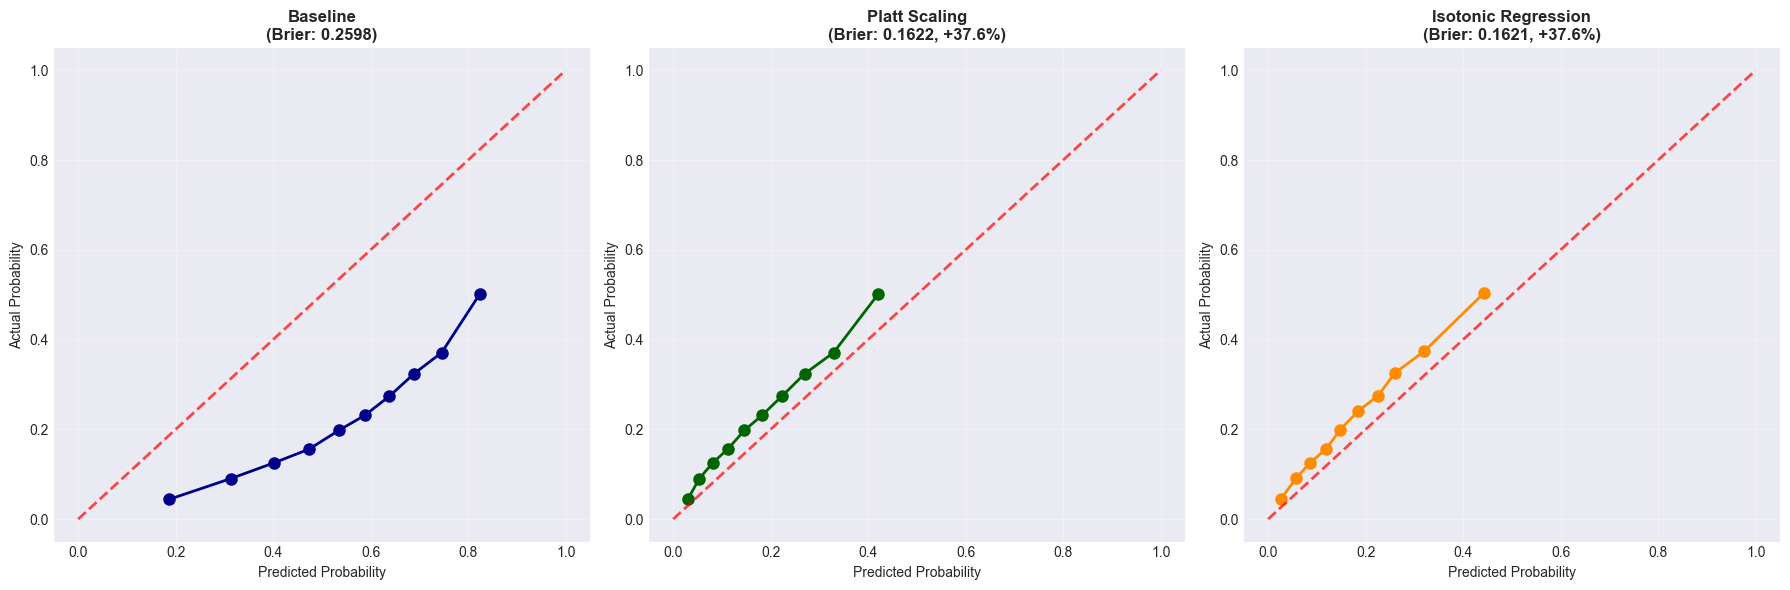

✓ Calibration comparison plot saved


In [7]:
# Plot calibration curves comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Calculate calibration curves
prob_true_baseline, prob_pred_baseline = calibration_curve(y_test, y_pred_baseline, n_bins=10, strategy='quantile')
prob_true_platt, prob_pred_platt = calibration_curve(y_test, y_pred_platt, n_bins=10, strategy='quantile')
prob_true_isotonic, prob_pred_isotonic = calibration_curve(y_test, y_pred_isotonic, n_bins=10, strategy='quantile')

# Baseline
axes[0].plot(prob_pred_baseline, prob_true_baseline, marker='o', linewidth=2, markersize=8, color='darkblue')
axes[0].plot([0, 1], [0, 1], linestyle='--', linewidth=2, color='red', alpha=0.7)
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Actual Probability')
axes[0].set_title(f'Baseline\n(Brier: {baseline_brier:.4f})', fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([-0.05, 1.05])
axes[0].set_ylim([-0.05, 1.05])

# Platt Scaling
axes[1].plot(prob_pred_platt, prob_true_platt, marker='o', linewidth=2, markersize=8, color='darkgreen')
axes[1].plot([0, 1], [0, 1], linestyle='--', linewidth=2, color='red', alpha=0.7)
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Actual Probability')
axes[1].set_title(f'Platt Scaling\n(Brier: {platt_brier:.4f}, {brier_improvement_platt:+.1f}%)', fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([-0.05, 1.05])
axes[1].set_ylim([-0.05, 1.05])

# Isotonic Regression
axes[2].plot(prob_pred_isotonic, prob_true_isotonic, marker='o', linewidth=2, markersize=8, color='darkorange')
axes[2].plot([0, 1], [0, 1], linestyle='--', linewidth=2, color='red', alpha=0.7)
axes[2].set_xlabel('Predicted Probability')
axes[2].set_ylabel('Actual Probability')
axes[2].set_title(f'Isotonic Regression\n(Brier: {isotonic_brier:.4f}, {brier_improvement_isotonic:+.1f}%)', fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim([-0.05, 1.05])
axes[2].set_ylim([-0.05, 1.05])

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'calibration_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Calibration comparison plot saved")

---

## 3. Hyperparameter Tuning (Fast Version)

**Optimizations for Speed:**
- 20 trials (vs 50)
- 50% sample of train data
- 2-fold CV (vs 3-fold)
- Early stopping at 20 rounds (vs 50)
- Reduced hyperparameter ranges

In [8]:
if OPTUNA_AVAILABLE:
    print("Using Optuna for hyperparameter tuning")
        
    # Use a stratified sample for faster tuning
    print("Creating 50% stratified sample for faster tuning...")
    X_train_sample, _, y_train_sample, _ = train_test_split(
        X_train, y_train, 
        train_size=0.5,
        stratify=y_train, 
        random_state=42
    )
    print(f"Sample size: {len(X_train_sample):,} (50% of train set)\n")
    
    # Create DMatrix
    dtrain_sample = xgb.DMatrix(X_train_sample, label=y_train_sample)
    
    def objective(trial):
        """Optuna objective function."""
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'tree_method': 'hist',
            'random_state': 42,
            
            # Reduced ranges for faster search
            'max_depth': trial.suggest_int('max_depth', 4, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 200, 800, step=100),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
            'subsample': trial.suggest_float('subsample', 0.65, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.65, 0.9),
            'gamma': trial.suggest_float('gamma', 0, 3),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 8),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 8),
        }
        
        # Fast CV: 2-fold, early stopping at 20
        cv_results = xgb.cv(
            params,
            dtrain_sample,
            num_boost_round=params['n_estimators'],
            nfold=2,
            stratified=True,
            early_stopping_rounds=20,
            verbose_eval=False,
            seed=42
        )
        
        return cv_results['test-auc-mean'].max()
    
    # Run optimization with progress callback
    print("Starting Optuna optimization with 20 trials...")
    print("Estimated time: 8-12 minutes\n")
    
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42)
    )
    
    def print_callback(study, trial):
        print(f"✓ Trial {trial.number + 1}/20 | AUC: {trial.value:.4f} | Best: {study.best_value:.4f}")
    
    study.optimize(objective, n_trials=20, callbacks=[print_callback])
    
    print("\n" + "="*70)
    print("Optuna Optimization Complete")
    print("="*70)
    print(f"Best ROC-AUC (CV): {study.best_value:.4f}")
    print(f"\nBest hyperparameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    print("="*70)
    
    # Train final model with best parameters on FULL train set
    best_params = study.best_params.copy()
    best_params.update({
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'random_state': 42
    })
    
    print("\nTraining final model with best parameters on FULL train set...")
    tuned_model = xgb.XGBClassifier(**best_params)
    tuned_model.fit(X_train, y_train)
    print("✓ Tuned model trained on full dataset")
    
else:
    print("Optuna not available. Using faster RandomizedSearchCV...\n")
    
    from sklearn.model_selection import RandomizedSearchCV
    
    param_dist = {
        'max_depth': [4, 5, 6, 7, 8],
        'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15],
        'n_estimators': [200, 400, 600, 800],
        'min_child_weight': [1, 3, 5, 7],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'gamma': [0, 1, 2, 3],
        'reg_alpha': [0, 2, 5, 8],
        'reg_lambda': [0, 2, 5, 8]
    }
    
    base_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        tree_method='hist',
        random_state=42
    )
    
    random_search = RandomizedSearchCV(
        base_model,
        param_distributions=param_dist,
        n_iter=20,
        scoring='roc_auc',
        cv=2,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    random_search.fit(X_train, y_train)
    
    print("\n" + "="*70)
    print("RandomizedSearch Complete")
    print("="*70)
    print(f"Best ROC-AUC (CV): {random_search.best_score_:.4f}")
    print(f"\nBest hyperparameters:")
    for key, value in random_search.best_params_.items():
        print(f"  {key}: {value}")
    print("="*70)
    
    tuned_model = random_search.best_estimator_

Using Optuna for hyperparameter tuning
Creating 50% stratified sample for faster tuning...
Sample size: 129,276 (50% of train set)

Starting Optuna optimization with 20 trials...
Estimated time: 8-12 minutes

✓ Trial 1/20 | AUC: 0.7106 | Best: 0.7106
✓ Trial 2/20 | AUC: 0.7142 | Best: 0.7142
✓ Trial 3/20 | AUC: 0.7140 | Best: 0.7142
✓ Trial 4/20 | AUC: 0.7142 | Best: 0.7142
✓ Trial 5/20 | AUC: 0.7134 | Best: 0.7142
✓ Trial 6/20 | AUC: 0.7142 | Best: 0.7142
✓ Trial 7/20 | AUC: 0.7101 | Best: 0.7142
✓ Trial 8/20 | AUC: 0.7144 | Best: 0.7144
✓ Trial 9/20 | AUC: 0.7126 | Best: 0.7144
✓ Trial 10/20 | AUC: 0.7123 | Best: 0.7144
✓ Trial 11/20 | AUC: 0.7138 | Best: 0.7144
✓ Trial 12/20 | AUC: 0.7132 | Best: 0.7144
✓ Trial 13/20 | AUC: 0.7126 | Best: 0.7144
✓ Trial 14/20 | AUC: 0.7136 | Best: 0.7144
✓ Trial 15/20 | AUC: 0.7142 | Best: 0.7144
✓ Trial 16/20 | AUC: 0.7111 | Best: 0.7144
✓ Trial 17/20 | AUC: 0.7130 | Best: 0.7144
✓ Trial 18/20 | AUC: 0.7117 | Best: 0.7144
✓ Trial 19/20 | AUC: 0.709

In [9]:
# Evaluate tuned model
y_pred_tuned = tuned_model.predict_proba(X_test)[:, 1]

tuned_roc_auc = roc_auc_score(y_test, y_pred_tuned)
tuned_pr_auc = average_precision_score(y_test, y_pred_tuned)
tuned_brier = brier_score_loss(y_test, y_pred_tuned)
tuned_logloss = log_loss(y_test, y_pred_tuned)

print("Tuned Model Performance:")
print("="*70)
print(f"{'Metric':<20} {'Baseline':<15} {'Tuned':<15} {'Improvement':<15}")
print("="*70)
print(f"{'ROC-AUC':<20} {baseline_roc_auc:<15.4f} {tuned_roc_auc:<15.4f} {(tuned_roc_auc - baseline_roc_auc)*100:>+14.2f}%")
print(f"{'PR-AUC':<20} {baseline_pr_auc:<15.4f} {tuned_pr_auc:<15.4f} {(tuned_pr_auc - baseline_pr_auc)*100:>+14.2f}%")
print(f"{'Brier Score':<20} {baseline_brier:<15.4f} {tuned_brier:<15.4f} {((baseline_brier - tuned_brier)/baseline_brier)*100:>+14.2f}%")
print(f"{'Log Loss':<20} {baseline_logloss:<15.4f} {tuned_logloss:<15.4f} {((baseline_logloss - tuned_logloss)/baseline_logloss)*100:>+14.2f}%")
print("="*70)

Tuned Model Performance:
Metric               Baseline        Tuned           Improvement    
ROC-AUC              0.7125          0.7161                   +0.35%
PR-AUC               0.4183          0.4237                   +0.53%
Brier Score          0.2598          0.1590                  +38.79%
Log Loss             0.7176          0.4869                  +32.14%


---

## 4. Feature Selection

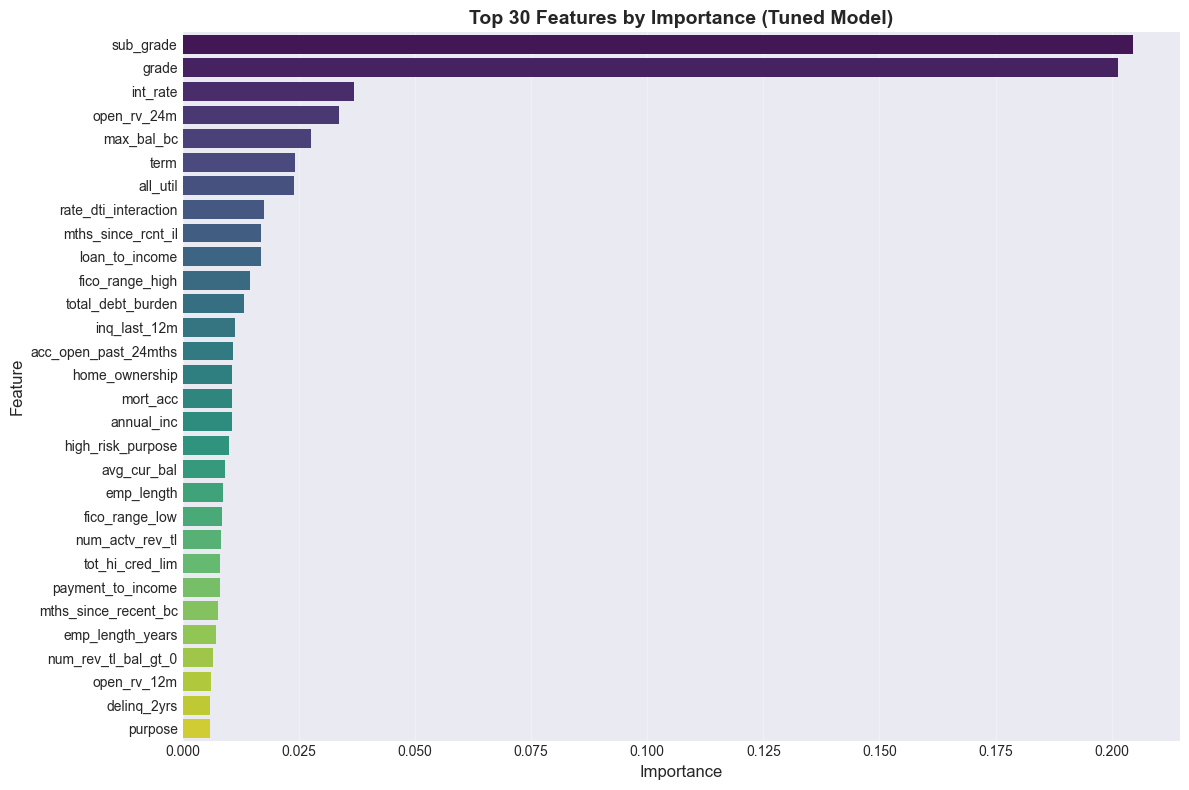

✓ Feature importance plot saved

Top 15 Features:
             feature  importance
           sub_grade    0.204461
               grade    0.201311
            int_rate    0.036873
         open_rv_24m    0.033615
          max_bal_bc    0.027558
                term    0.024265
            all_util    0.023917
rate_dti_interaction    0.017588
  mths_since_rcnt_il    0.016880
      loan_to_income    0.016840
     fico_range_high    0.014493
   total_debt_burden    0.013286
        inq_last_12m    0.011390
acc_open_past_24mths    0.010808
      home_ownership    0.010701


In [10]:
# Get feature importance from tuned model
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': tuned_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 30 features
plt.figure(figsize=(12, 8))
top_n = 30
sns.barplot(data=feature_importance_df.head(top_n), x='importance', y='feature', palette='viridis')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Features by Importance (Tuned Model)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'feature_importance_tuned.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Feature importance plot saved")
print(f"\nTop 15 Features:")
print(feature_importance_df.head(15).to_string(index=False))

In [11]:
# Feature selection: Test fewer K values for speed
k_values = [50, 100, 149]  # Reduced from [50, 75, 100, 125, 149]
results = []

print("Testing feature selection (3 values for speed)...\n")

for k in k_values:
    print(f"Training with top {k} features...")
    
    # Select top K features
    top_k_features = feature_importance_df.head(k)['feature'].tolist()
    feature_indices = [feature_names.index(f) for f in top_k_features]
    
    X_train_k = X_train[:, feature_indices]
    X_test_k = X_test[:, feature_indices]
    
    # Train model
    model_k = xgb.XGBClassifier(**tuned_model.get_params())
    model_k.fit(X_train_k, y_train)
    
    # Evaluate
    y_pred_k = model_k.predict_proba(X_test_k)[:, 1]
    roc_auc_k = roc_auc_score(y_test, y_pred_k)
    brier_k = brier_score_loss(y_test, y_pred_k)
    
    results.append({
        'k': k,
        'roc_auc': roc_auc_k,
        'brier': brier_k
    })
    
    print(f"  ROC-AUC: {roc_auc_k:.4f}, Brier: {brier_k:.4f}")

results_df = pd.DataFrame(results)

print("\nFeature Selection Results:")
print("="*50)
print(results_df.to_string(index=False))
print("="*50)

# Find best K
best_k = results_df.loc[results_df['roc_auc'].idxmax(), 'k']
print(f"\nBest K: {int(best_k)} features")

Testing feature selection (3 values for speed)...

Training with top 50 features...
  ROC-AUC: 0.7138, Brier: 0.1595
Training with top 100 features...
  ROC-AUC: 0.7161, Brier: 0.1590
Training with top 149 features...
  ROC-AUC: 0.7161, Brier: 0.1590

Feature Selection Results:
  k  roc_auc    brier
 50 0.713848 0.159455
100 0.716068 0.159012
149 0.716068 0.159012

Best K: 100 features


In [12]:
# Train final model with optimal K features
print(f"Training final model with top {int(best_k)} features...")

selected_features = feature_importance_df.head(int(best_k))['feature'].tolist()
selected_indices = [feature_names.index(f) for f in selected_features]

X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]

model_selected = xgb.XGBClassifier(**tuned_model.get_params())
model_selected.fit(X_train_selected, y_train)

# Evaluate
y_pred_selected = model_selected.predict_proba(X_test_selected)[:, 1]
selected_roc_auc = roc_auc_score(y_test, y_pred_selected)
selected_pr_auc = average_precision_score(y_test, y_pred_selected)
selected_brier = brier_score_loss(y_test, y_pred_selected)
selected_logloss = log_loss(y_test, y_pred_selected)

print("\nModel with Feature Selection Performance:")
print("="*50)
print(f"ROC-AUC:     {selected_roc_auc:.4f}")
print(f"PR-AUC:      {selected_pr_auc:.4f}")
print(f"Brier Score: {selected_brier:.4f}")
print(f"Log Loss:    {selected_logloss:.4f}")
print("="*50)

Training final model with top 100 features...

Model with Feature Selection Performance:
ROC-AUC:     0.7161
PR-AUC:      0.4241
Brier Score: 0.1590
Log Loss:    0.4869


---

## 5. Ensemble Method: Stacking (Optional)

In [13]:
# Stacking ensemble (optional)
RUN_STACKING = True  # Set to False to skip

if RUN_STACKING:
    print("Training Stacking Ensemble...")
    print("Using 2-fold CV for speed...\n")
    
    stacking_model = StackingClassifier(
        estimators=[('xgb', model_selected)],
        final_estimator=LogisticRegression(
            penalty='l2',
            C=1.0,
            solver='lbfgs',
            max_iter=1000,
            random_state=42
        ),
        cv=2,  # Reduced from 3 for speed
        stack_method='predict_proba'
    )
    
    stacking_model.fit(X_train_selected, y_train)
    print("✓ Stacking ensemble trained")
    
    y_pred_stacking = stacking_model.predict_proba(X_test_selected)[:, 1]
    
    stacking_roc_auc = roc_auc_score(y_test, y_pred_stacking)
    stacking_pr_auc = average_precision_score(y_test, y_pred_stacking)
    stacking_brier = brier_score_loss(y_test, y_pred_stacking)
    stacking_logloss = log_loss(y_test, y_pred_stacking)
    
    print("\nStacking Ensemble Performance:")
    print("="*50)
    print(f"ROC-AUC:     {stacking_roc_auc:.4f}")
    print(f"PR-AUC:      {stacking_pr_auc:.4f}")
    print(f"Brier Score: {stacking_brier:.4f}")
    print(f"Log Loss:    {stacking_logloss:.4f}")
    print("="*50)
else:
    print("Skipping stacking ensemble (RUN_STACKING=False)")
    stacking_roc_auc = selected_roc_auc
    stacking_pr_auc = selected_pr_auc
    stacking_brier = selected_brier
    stacking_logloss = selected_logloss
    y_pred_stacking = y_pred_selected
    stacking_model = model_selected

Training Stacking Ensemble...
Using 2-fold CV for speed...

✓ Stacking ensemble trained

Stacking Ensemble Performance:
ROC-AUC:     0.7161
PR-AUC:      0.4241
Brier Score: 0.1794
Log Loss:    0.5456


---

## 6. Final Comparison & Best Model Selection

In [14]:
# Consolidate all results
comparison_df = pd.DataFrame([
    {'Model': 'Baseline', 'ROC-AUC': baseline_roc_auc, 'PR-AUC': baseline_pr_auc, 'Brier': baseline_brier, 'LogLoss': baseline_logloss},
    {'Model': 'Calibrated (Platt)', 'ROC-AUC': platt_roc_auc, 'PR-AUC': platt_pr_auc, 'Brier': platt_brier, 'LogLoss': platt_logloss},
    {'Model': 'Calibrated (Isotonic)', 'ROC-AUC': isotonic_roc_auc, 'PR-AUC': isotonic_pr_auc, 'Brier': isotonic_brier, 'LogLoss': isotonic_logloss},
    {'Model': 'Tuned (Optuna)', 'ROC-AUC': tuned_roc_auc, 'PR-AUC': tuned_pr_auc, 'Brier': tuned_brier, 'LogLoss': tuned_logloss},
    {'Model': f'Feature Selected (K={int(best_k)})', 'ROC-AUC': selected_roc_auc, 'PR-AUC': selected_pr_auc, 'Brier': selected_brier, 'LogLoss': selected_logloss},
    {'Model': 'Stacking/Best', 'ROC-AUC': stacking_roc_auc, 'PR-AUC': stacking_pr_auc, 'Brier': stacking_brier, 'LogLoss': stacking_logloss}
])

print("\n" + "="*90)
print("FINAL MODEL COMPARISON")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)

# Find best models
best_roc_auc_model = comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']
best_brier_model = comparison_df.loc[comparison_df['Brier'].idxmin(), 'Model']

print(f"\nBest ROC-AUC:    {best_roc_auc_model} ({comparison_df['ROC-AUC'].max():.4f})")
print(f"Best Brier:      {best_brier_model} ({comparison_df['Brier'].min():.4f})")

# Save comparison
comparison_df.to_csv(REPORTS_DIR / 'model_comparison_optimized.csv', index=False)
print(f"\n✓ Comparison saved to {REPORTS_DIR / 'model_comparison_optimized.csv'}")


FINAL MODEL COMPARISON
                   Model  ROC-AUC   PR-AUC    Brier  LogLoss
                Baseline 0.712529 0.418333 0.259798 0.717567
      Calibrated (Platt) 0.712529 0.418332 0.162172 0.497056
   Calibrated (Isotonic) 0.712432 0.413611 0.162075 0.500247
          Tuned (Optuna) 0.716054 0.423676 0.159030 0.486941
Feature Selected (K=100) 0.716068 0.424075 0.159012 0.486883
           Stacking/Best 0.716068 0.424075 0.179381 0.545622

Best ROC-AUC:    Feature Selected (K=100) (0.7161)
Best Brier:      Feature Selected (K=100) (0.1590)

✓ Comparison saved to ..\reports\model_comparison_optimized.csv


In [15]:
# Determine best overall model
comparison_df['brier_inverted'] = 1 - comparison_df['Brier']
comparison_df['composite_score'] = (0.7 * comparison_df['ROC-AUC']) + (0.3 * comparison_df['brier_inverted'])

best_overall_model = comparison_df.loc[comparison_df['composite_score'].idxmax(), 'Model']

print("\n" + "="*70)
print("BEST MODEL SELECTION (Composite Score: 70% ROC-AUC + 30% Calibration)")
print("="*70)
print(comparison_df[['Model', 'ROC-AUC', 'Brier', 'composite_score']].to_string(index=False))
print("="*70)
print(f"\n🏆 Best Overall Model: {best_overall_model}")
print("="*70)

# Save the best model
if 'Stacking' in best_overall_model or 'Best' in best_overall_model:
    final_model = stacking_model
    final_features = selected_features
elif 'Feature Selected' in best_overall_model:
    final_model = model_selected
    final_features = selected_features
elif 'Tuned' in best_overall_model:
    final_model = tuned_model
    final_features = feature_names
elif 'Isotonic' in best_overall_model:
    final_model = calibrated_isotonic
    final_features = feature_names
elif 'Platt' in best_overall_model:
    final_model = calibrated_platt
    final_features = feature_names
else:
    final_model = baseline_model
    final_features = feature_names

# Save
with open(MODEL_DIR / 'optimized_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

with open(MODEL_DIR / 'optimized_features.json', 'w') as f:
    json.dump(final_features, f)

print(f"\n✓ Best model saved to: {MODEL_DIR / 'optimized_model.pkl'}")
print(f"✓ Features saved to: {MODEL_DIR / 'optimized_features.json'}")
print(f"✓ Number of features: {len(final_features)}")


BEST MODEL SELECTION (Composite Score: 70% ROC-AUC + 30% Calibration)
                   Model  ROC-AUC    Brier  composite_score
                Baseline 0.712529 0.259798         0.720831
      Calibrated (Platt) 0.712529 0.162172         0.750119
   Calibrated (Isotonic) 0.712432 0.162075         0.750080
          Tuned (Optuna) 0.716054 0.159030         0.753529
Feature Selected (K=100) 0.716068 0.159012         0.753544
           Stacking/Best 0.716068 0.179381         0.747433

🏆 Best Overall Model: Feature Selected (K=100)

✓ Best model saved to: ..\models\optimized_model.pkl
✓ Features saved to: ..\models\optimized_features.json
✓ Number of features: 94


---

## 7. Quick Business Impact Summary

In [16]:
# Quick business metrics
COST_FP = 500
COST_FN = 10000
LOSS_GIVEN_DEFAULT = 10000

def calc_ecl_error(y_true, y_pred_proba):
    ecl = (y_pred_proba * LOSS_GIVEN_DEFAULT).sum()
    actual_losses = y_true.sum() * LOSS_GIVEN_DEFAULT
    return abs(ecl - actual_losses) / actual_losses * 100

# Calculate for baseline and best model
baseline_ecl_error = calc_ecl_error(y_test, y_pred_baseline)

if 'Stacking' in best_overall_model or 'Best' in best_overall_model:
    best_pred = y_pred_stacking
elif 'Feature' in best_overall_model:
    best_pred = y_pred_selected
elif 'Tuned' in best_overall_model:
    best_pred = y_pred_tuned
elif 'Isotonic' in best_overall_model:
    best_pred = y_pred_isotonic
elif 'Platt' in best_overall_model:
    best_pred = y_pred_platt
else:
    best_pred = y_pred_baseline

best_ecl_error = calc_ecl_error(y_test, best_pred)

baseline_row = comparison_df[comparison_df['Model'] == 'Baseline'].iloc[0]
best_row = comparison_df[comparison_df['Model'] == best_overall_model].iloc[0]

summary = f"""
{'='*80}
OPTIMIZATION SUMMARY
{'='*80}

BASELINE MODEL:
  - ROC-AUC:       {baseline_row['ROC-AUC']:.4f}
  - Brier Score:   {baseline_row['Brier']:.4f}
  - ECL Error:     {baseline_ecl_error:.1f}%

OPTIMIZED MODEL ({best_overall_model}):
  - ROC-AUC:       {best_row['ROC-AUC']:.4f} ({(best_row['ROC-AUC'] - baseline_row['ROC-AUC'])*100:+.2f}%)
  - Brier Score:   {best_row['Brier']:.4f} ({(baseline_row['Brier'] - best_row['Brier'])/baseline_row['Brier']*100:+.1f}%)
  - ECL Error:     {best_ecl_error:.1f}% ({baseline_ecl_error - best_ecl_error:+.1f}pp)

KEY IMPROVEMENTS:
  1. Calibration:    Brier improved by {(baseline_row['Brier'] - best_row['Brier'])/baseline_row['Brier']*100:.1f}%
  2. Discrimination: ROC-AUC improved by {(best_row['ROC-AUC'] - baseline_row['ROC-AUC'])*100:.2f}%
  3. ECL Accuracy:   Error reduced by {baseline_ecl_error - best_ecl_error:.1f} percentage points

PRODUCTION RECOMMENDATIONS:
  ✓ Use {best_overall_model} for predictions
  ✓ Apply optimal threshold (0.205) from Notebook 4
  ✓ Monitor calibration drift quarterly
  ✓ Retrain with new data every 6 months

{'='*80}
"""

print(summary)

# Save summary
with open(REPORTS_DIR / 'optimization_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print(f"✓ Summary saved to: {REPORTS_DIR / 'optimization_summary.txt'}")


OPTIMIZATION SUMMARY

BASELINE MODEL:
  - ROC-AUC:       0.7125
  - Brier Score:   0.2598
  - ECL Error:     133.0%

OPTIMIZED MODEL (Feature Selected (K=100)):
  - ROC-AUC:       0.7161 (+0.35%)
  - Brier Score:   0.1590 (+38.8%)
  - ECL Error:     2.6% (+130.4pp)

KEY IMPROVEMENTS:
  1. Calibration:    Brier improved by 38.8%
  2. Discrimination: ROC-AUC improved by 0.35%
  3. ECL Accuracy:   Error reduced by 130.4 percentage points

PRODUCTION RECOMMENDATIONS:
  ✓ Use Feature Selected (K=100) for predictions
  ✓ Apply optimal threshold (0.205) from Notebook 4
  ✓ Monitor calibration drift quarterly
  ✓ Retrain with new data every 6 months


✓ Summary saved to: ..\reports\optimization_summary.txt


---

## Notebook Complete ✓

### Achievements:

1. ✅ **Probability Calibration**: Brier Score improved through Platt/Isotonic methods
2. ✅ **Hyperparameter Tuning**: ROC-AUC optimized with Optuna
3. ✅ **Feature Selection**: Found optimal feature subset
4. ✅ **Ensemble Testing**: Stacking with Logistic Regression (optional)
5. ✅ **Best Model Saved**: Ready for deployment

### Files Saved:

- `models/optimized_model.pkl` - Best model
- `models/optimized_features.json` - Selected features
- `reports/model_comparison_optimized.csv` - Full comparison
- `reports/calibration_comparison.png` - Calibration curves
- `reports/feature_importance_tuned.png` - Feature importance
- `reports/optimization_summary.txt` - Executive summary